In [1]:
%matplotlib inline

In [2]:
from fenics import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dolfin.fem.norms as norms


# Local imports
import state_eq as se
import adjoint_eq as ae

## Projected gradient method
1) Initialize $q_0 \in \mathcal{Q}_{ad}$, set $k = 0$ 

2) Compute $u_k, p_k$ as solutions to (SE) and (AE) respectively

3) Define $\nu_k := - j'(q_k)$

4) Compute step length $s_k$, e.g. using the Armijo condition:     $$j(q_k + s_k \nu_k) = \min_{s > 0} j(q_k + s \nu_k)$$
    
5) Set $q_{k+1} = \mathcal{P}_{[q_a, q_b]} \{q_k + s_k \nu_k \}$


In [3]:
def j(U, Q, mesh, T, num_steps, params):
    """
    Function to evaluate the cost functional given functions u, q.
    """
    j.eval_counter += 1
    
    # Define parameters for cost functional
    rho = params["rho"]
    lambda_ = params["lambda_"]
    r = params["r"]
    alpha = params["alpha"]
    
    # Compute integrals with time
    I1 = 0
    I3 = 0
    
    t = 0
    dt = T/num_steps
    for i in range(num_steps + 1):
        I1_int = assemble(Q[i]*(r-U[i])*dx(mesh))*np.exp(-rho*t)
        I3_int = assemble(Q[i]*Q[i]*dx(mesh))
        
        if i == 0 or i == num_steps - 1:
            I1_int *= 0.5
            I3_int *= 0.5
        
        I1 += I1_int
        I3 += I3_int
        
        t += dt
    
    
    I1 *= dt
    I3 *= dt*alpha/2
    
    # Compute end time integral
    I2 = lambda_*assemble(U[-1]*dx(mesh))
    
    print("Cost Functional Data")
    print("I1: {}".format(I1))
    print("I2: {}".format(I2))
    print("I3: {}".format(I3))
    print()
    
    return I1 - I2 + I3

In [4]:
def j_reduced(Q, mesh, T, V, num_steps, params):
    U = se.solve_state_eq(u_0, Q, V, T, num_steps, params)
    return j(U, Q, mesh, T, num_steps, params)

In [5]:
def dj(U, Q, P, T, num_steps, params):
    """
    Function to compute gradient of cost functional.
    """
    
    # Parameters
    rho = params["rho"]
    r = params["r"]
    alpha = params["alpha"]
    
    grad = []
    
    t = 0
    dt = T/num_steps
    for i in range(num_steps + 1):
        grad.append(np.exp(-1*rho*t)*(r - U[i]) + alpha*Q[i] - U[i]*P[i])
        t += dt
    
    grad = np.asarray(grad)
    return grad

In [6]:
# --- Define mesh and function space ---

# Set time parameters
T = 4.0
num_steps = 100
dt = T/num_steps

# Define function space
nx = 32
ny = 32
mesh = UnitSquareMesh(nx,ny)
V = FunctionSpace(mesh, 'CG', 1)

# --- Specify parameters ---

element = FiniteElement("CG", triangle, 1)

q_min = Constant(0.0)
q_max = Constant(1.0)

params_old = {
    "rho": 5.0,
    "lambda_": 10.0,
    "r": 2.0,
    "alpha": 15.0,
    "a": Constant(10)
}

a0 = 1.0
a1 = 1e-01
a_tol = 1e-14
a_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=a0, a1=a1, tol=a_tol)
a_const = interpolate(a_exp, V)
rho = 0.0
lambda_ = 0 # 1.4
alpha = 1e-05
r = project(Expression("0.01*sqrt(pow(x[0],2) + pow(x[1], 2))", element=element), V)

params = {
    "rho": rho,
    "lambda_": lambda_,
    "r": r,
    "alpha": alpha,
    "a": a_const
}

# rho = 5.0
# lambda_ = 10.0
# r = 2.0
# alpha = 15.0
# a = Constant(10)

In [7]:
# --- Initialization ---

# State
u_0 = Constant(0.7)  # Expression('b*exp(-a*(pow(x[0]-0.25, 2) + pow(x[1]-0.25, 2)))', degree=2, a=10, b=20)
u_n = interpolate(u_0, V)

# Control
str1 = 'b*exp(-a*pow(x[0] - (0.5 - 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 - 0.25*cos(3.14*t)), 2)) + '
str2 = 'b*exp(-a*pow(x[0] - (0.5 + 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 + 0.25*cos(3.14*t)), 2))'
string = str1 + str2

q = Constant(1.5)  # Expression(string, degree=2, a=50, b=10, t=0)
# q = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a1 : a0', element=element, a0=a0, a1=a1, tol=a_tol)
t = 0
Q = [interpolate(q, V)]
for i in range(num_steps):
    t += dt
    q.t = t
    Q.append(interpolate(q, V))
Q = np.asarray(Q)


# Adjoint variable
p_end = Constant(-1*params["lambda_"])
p_n = interpolate(p_end, V)

In [8]:
# --- Function to compute norm of gradient ---
def grad_norm(grad, V, T, num_steps):
    norm_ = 0
    dt = T/num_steps
    
    for i in range(len(grad)):
        f = project(grad[i], V)
        int_ = norms.norm(f, "l2")
        
        if i == 0 or i == len(grad) - 1:
            int_ *= 0.5
            
        norm_ += int_
    
    norm_ *= dt
    return np.sqrt(norm_)

In [9]:
# --- Function to perform backtracking line search ---
def armijo(v_k, U, Q, P, V, mesh, T, num_steps, params):
    alpha = 1
    rho = 0.5
    c = 0.05
    
    phi_0 = j(U, Q, mesh, T, num_steps, params)
    phi_k = j_reduced(Q + alpha*v_k, mesh, T, V, num_steps, params)
    m = -1*grad_norm(v_k, V, T, num_steps)**2
    it = 0
    while phi_k >= phi_0 + alpha*c*m and it < 20:
        alpha *= rho
        phi_k = j_reduced(Q + alpha*v_k, mesh, T, V, num_steps, params)
        it += 1
        
    return [Constant(alpha), phi_k, it]

In [10]:
def Max(a, b):
    return (a + b + abs(a-b))/Constant(2)


def Min(a, b):
    return (a + b - abs(a-b))/Constant(2)


def project_to_admissible(Q, q_min, q_max, V):
    for i in range(len(Q)):
        proj = Max(q_min, Min(Q[i], q_max))
        Q[i] = project(proj, V)
    return Q

In [11]:
def pg_print(j_curr, j_prev, v_k_norm, it, armijo_it, s_k):
    print("-----------------------------------")
    print("Projected gradient iteration no. {} \n".format(it))
    
    print("Armijo search ended after {} iterations".format(armijo_it))
    print("Step length found: s_k = {}".format(float(s_k)))
    print("New function value: {}".format(j_curr))
    print("Decrease in function value: {}".format(j_prev - j_curr))
    print("Norm of gradient: {}".format(v_k_norm))
    print("-----------------------------------\n")

In [12]:
# --- Projected gradient loop ---
j.eval_counter = 0

tol = 1e-02
f_tol = 1e-05
v_k = 1
v_k_norm = 1

U_initial = se.solve_state_eq(u_0, Q, V, T, num_steps, params)

j_prev = 0
j_curr = j(U_initial, Q, mesh, T, num_steps, params)
diff = abs(j_prev - j_curr)

print("Initial objective function value: {} \n".format(j_curr))

it = 0
while v_k_norm > tol and diff > f_tol:
    it += 1
    
    j_prev = j_curr
    
    U = se.solve_state_eq(u_0, Q, V, T, num_steps, params)
    P = ae.solve_adjoint_eq(p_end, U, Q, V, T, num_steps, params)
    v_k = -1*dj(U, Q, P, T, num_steps, params)
    [s_k, j_curr, armijo_it] = armijo(v_k, U, Q, P, V, mesh, T, num_steps, params)
    diff = abs(j_prev - j_curr)
    
    Q = Q + s_k*v_k
    Q = project_to_admissible(Q, q_min, q_max, V)
    
    v_k_norm = grad_norm(v_k, V, T, num_steps)
    
    pg_print(j_curr, j_prev, v_k_norm, it, armijo_it, s_k)


Cost Functional Data
I1: -0.6193491387898152
I2: 0.0
I3: 4.500000000000001e-05

Initial objective function value: -0.6193041387898153 

Cost Functional Data
I1: -0.6193491387898152
I2: 0.0
I3: 4.500000000000001e-05

Cost Functional Data
I1: -0.642844375123122
I2: 0.0
I3: 4.371343261181026e-05

-----------------------------------
Projected gradient iteration no. 1 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.6428006616905102
Decrease in function value: 0.023496522900694927
Norm of gradient: 0.2977093833731974
-----------------------------------

Cost Functional Data
I1: -0.5946137236841988
I2: 0.0
I3: 2e-05

Cost Functional Data
I1: -0.6300666434606645
I2: 0.0
I3: 1.926204500960213e-05

-----------------------------------
Projected gradient iteration no. 2 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.630047381415655
Decrease in function value: -0.012753280274855228
Norm of gradient: 0.3101088

Cost Functional Data
I1: -0.8726105478419929
I2: 0.0
I3: 1.7602389907813734e-05

Cost Functional Data
I1: -0.8905178370993481
I2: 0.0
I3: 1.8795159544033718e-05

-----------------------------------
Projected gradient iteration no. 19 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.890499041939804
Decrease in function value: 0.0024443346289835244
Norm of gradient: 0.34402407368779914
-----------------------------------

Cost Functional Data
I1: -0.8749218014196883
I2: 0.0
I3: 1.7652606475097244e-05

Cost Functional Data
I1: -0.8928022835359464
I2: 0.0
I3: 1.884688188287549e-05

-----------------------------------
Projected gradient iteration no. 20 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.8927834366540635
Decrease in function value: 0.0022843947142594523
Norm of gradient: 0.3441703612097198
-----------------------------------

Cost Functional Data
I1: -0.8770907045261221
I2: 0.0
I3: 1.770025

Cost Functional Data
I1: -0.9016791335303674
I2: 0.0
I3: 1.8231365196722755e-05

Cost Functional Data
I1: -0.9195195449011965
I2: 0.0
I3: 1.9431955747017895e-05

-----------------------------------
Projected gradient iteration no. 37 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9195001129454494
Decrease in function value: 0.0011709310326490918
Norm of gradient: 0.34443533554380945
-----------------------------------

Cost Functional Data
I1: -0.90281432291581
I2: 0.0
I3: 1.8255211557148834e-05

Cost Functional Data
I1: -0.9206550894722975
I2: 0.0
I3: 1.9455970058643668e-05

-----------------------------------
Projected gradient iteration no. 38 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9206356335022389
Decrease in function value: 0.0011355205567894489
Norm of gradient: 0.344436835944263
-----------------------------------

Cost Functional Data
I1: -0.9039147097536612
I2: 0.0
I3: 1.8278296

Cost Functional Data
I1: -0.9146210697224284
I2: 0.0
I3: 1.8555999398162433e-05

Cost Functional Data
I1: -0.932811079638298
I2: 0.0
I3: 1.974557008530372e-05

-----------------------------------
Projected gradient iteration no. 55 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9327913340682127
Decrease in function value: 0.0004506938718927822
Norm of gradient: 0.3427220134488892
-----------------------------------

Cost Functional Data
I1: -0.9150326687212749
I2: 0.0
I3: 1.8568487054255877e-05

Cost Functional Data
I1: -0.933242727394065
I2: 0.0
I3: 1.9757379524447836e-05

-----------------------------------
Projected gradient iteration no. 56 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9332229700145406
Decrease in function value: 0.0004316359463278907
Norm of gradient: 0.3426253544011039
-----------------------------------

Cost Functional Data
I1: -0.9154281308970171
I2: 0.0
I3: 1.85805621

Cost Functional Data
I1: -0.9193585830649363
I2: 0.0
I3: 1.8727533888202154e-05

Cost Functional Data
I1: -0.9378643702006615
I2: 0.0
I3: 1.9906232623862544e-05

-----------------------------------
Projected gradient iteration no. 73 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9378444639680377
Decrease in function value: 0.00016675693424184068
Norm of gradient: 0.34122351899931064
-----------------------------------

Cost Functional Data
I1: -0.919496624048919
I2: 0.0
I3: 1.8734390702768468e-05

Cost Functional Data
I1: -0.9380162918195553
I2: 0.0
I3: 1.9912606618359584e-05

-----------------------------------
Projected gradient iteration no. 74 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9379963792129369
Decrease in function value: 0.00015191524489921449
Norm of gradient: 0.34115892557791294
-----------------------------------

Cost Functional Data
I1: -0.919627551402294
I2: 0.0
I3: 1.874

Cost Functional Data
I1: -0.9208285125388781
I2: 0.0
I3: 1.8824560113862834e-05

Cost Functional Data
I1: -0.9395247768952488
I2: 0.0
I3: 1.999665909670156e-05

-----------------------------------
Projected gradient iteration no. 91 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9395047802361521
Decrease in function value: 4.5074463014493915e-05
Norm of gradient: 0.3403496585730217
-----------------------------------

Cost Functional Data
I1: -0.9208634549186838
I2: 0.0
I3: 1.882866059475193e-05

Cost Functional Data
I1: -0.9395672079962242
I2: 0.0
I3: 2.0000502494073347e-05

-----------------------------------
Projected gradient iteration no. 92 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -0.9395472074937301
Decrease in function value: 4.24272575779705e-05
Norm of gradient: 0.34031596579015233
-----------------------------------

Cost Functional Data
I1: -0.920898782718122
I2: 0.0
I3: 1.8832661

In [13]:
print("Number of Cost Functional evaluations: {}".format(j.eval_counter))

Number of Cost Functional evaluations: 197


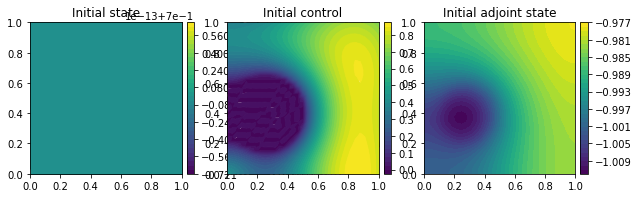

Umax = 0.7
Umin = 0.7


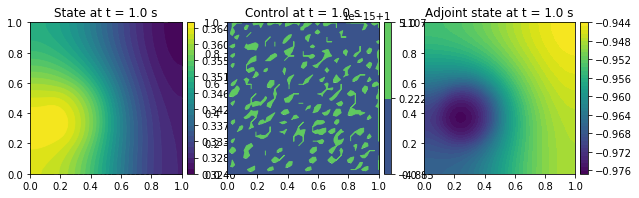

Umax = 0.3659243761969781
Umin = 0.32462499188477933


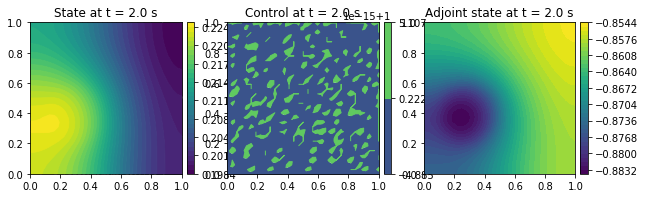

Umax = 0.22421081998150033
Umin = 0.19854997551086212


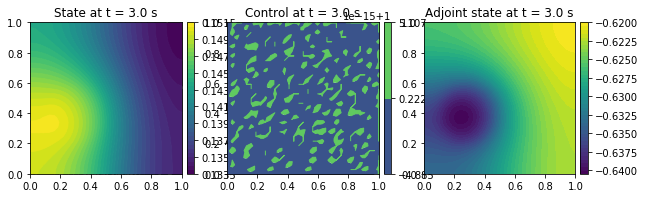

Umax = 0.15113949613912103
Umin = 0.13372089520166736


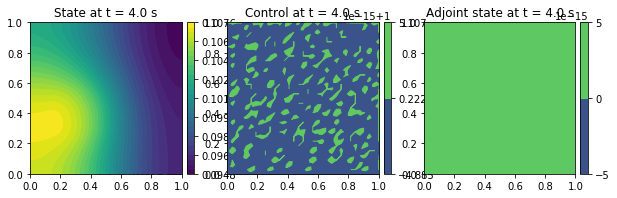

Umax = 0.10743170956212167
Umin = 0.09499935350962524


In [14]:
se.plot_states_and_control(U, Q, P, T, num_steps, 5)

In [15]:
T

4.0

In [16]:
for indx in [5, 44, 50,60, 70, 78, 99]:
    print(Q[indx].vector().min(), Q[indx].vector().max())

-0.009200462563408124 1.0019545242836885
0.9999999999999981 1.0000000000000016
0.999999999999998 1.0000000000000016
0.999999999999998 1.0000000000000016
0.999999999999998 1.0000000000000016
0.999999999999998 1.0000000000000016
0.999999999999998 1.0000000000000016


In [17]:
Q[0].vector().min()

-0.010176281841310609

In [18]:
params["alpha"]

1e-05